# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import pandas as pd
import cv2
import math
import numpy as np
import random
import requests
import glob
from PIL import Image


from tqdm import tqdm
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise
from sklearn.utils import shuffle



import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# TODO: Fill this in based on where you saved the training and testing data

PATH = 'C:/Users/asaga/Documents/CVND/Self Driving car NanoDegree/Project 3/CarND-Traffic-Sign-Classifier-Project'

training_file = os.path.join(PATH,'traffic-signs-data/train.p')
validation_file = os.path.join(PATH,'traffic-signs-data/valid.p')
testing_file = os.path.join(PATH,'traffic-signs-data/test.p')

classes_data = pd.read_csv(os.path.join(PATH,'signnames.csv' ))
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

#Assert each image has its label associated
assert(len(X_train) == len(y_train)),'Number of Images are not equal to labels'
assert(len(X_test) == len(y_test)),'Number of Images are not equal to labels'
assert(len(X_valid) == len(y_valid)),'Number of Images are not equal to labels'

#Assert shape of the images is 32x32x3
assert(X_train.shape[1:] == (32,32,3)), 'Image Dimensions is not 32x32x3'
assert(X_test.shape[1:] == (32,32,3)), 'Image Dimensions is not 32x32x3'
assert(X_valid.shape[1:] == (32,32,3)), 'Image Dimensions is not 32x32x3'

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(classes_data)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Output Classes

In [4]:
print(classes_data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [5]:
print(classes_data['SignName'][0])

Speed limit (20km/h)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.


Speed limit (80km/h)


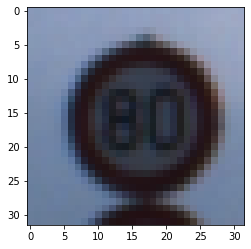

In [7]:
index = random.randint(0, len(X_train))
train_image = X_train[index].squeeze()

label = classes_data['SignName'][y_train[index]]
plt.imshow(train_image)
print(label)

### Visualize Images of each Class 

In [8]:
len(X_train[y_train==40])

300

### Training Set

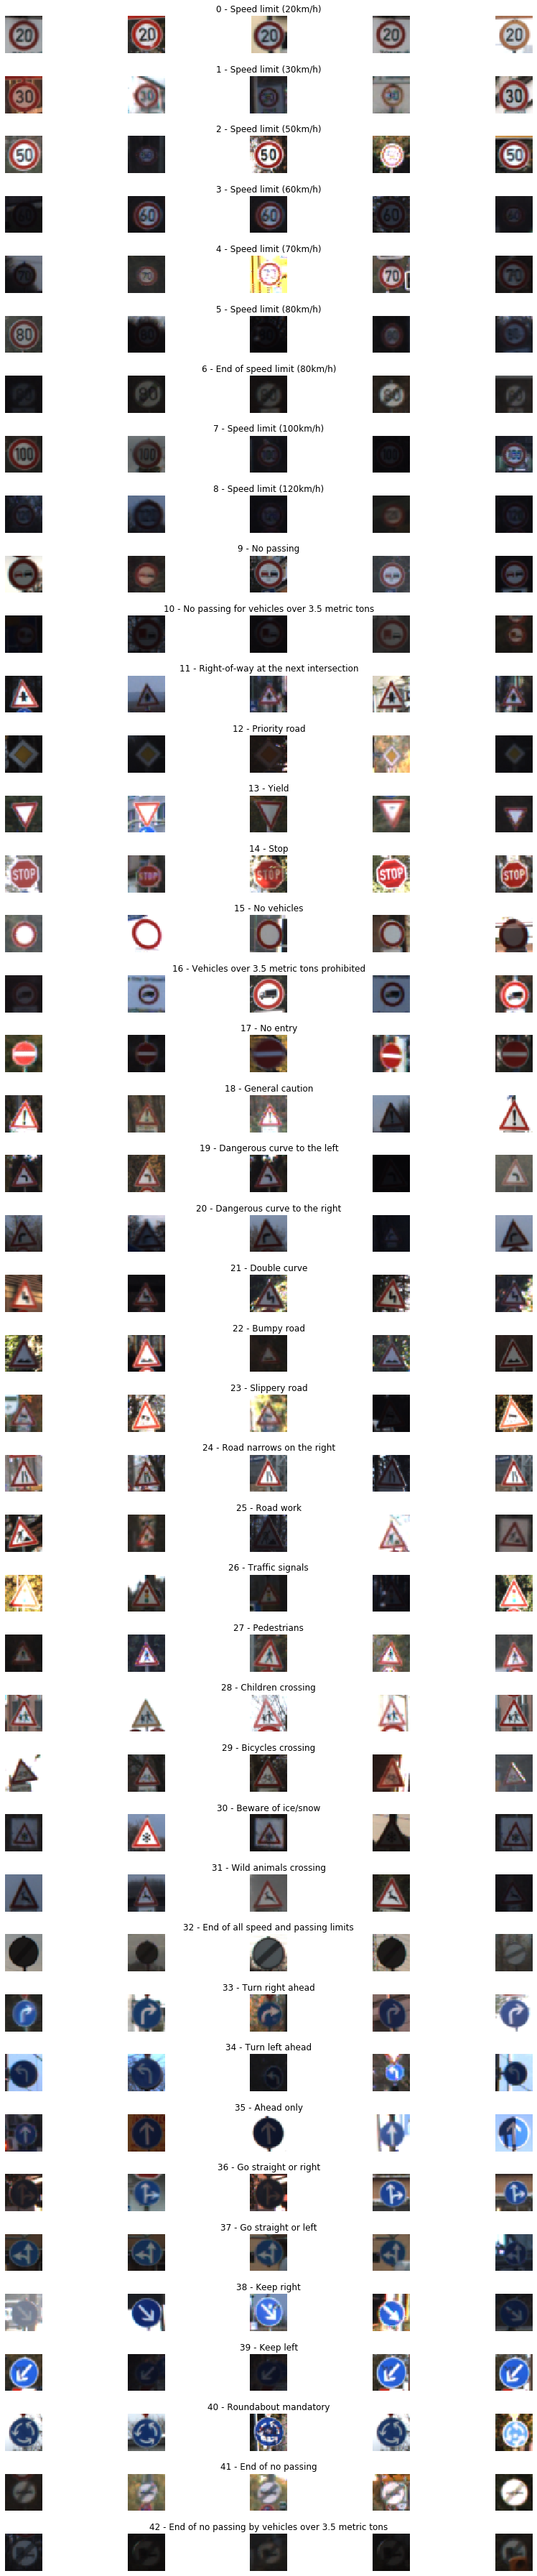

In [9]:
train_num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(12,50))
fig.tight_layout()

for i in range(cols):
    for j, row in classes_data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            train_num_of_samples.append(len(x_selected))

### Validation Set

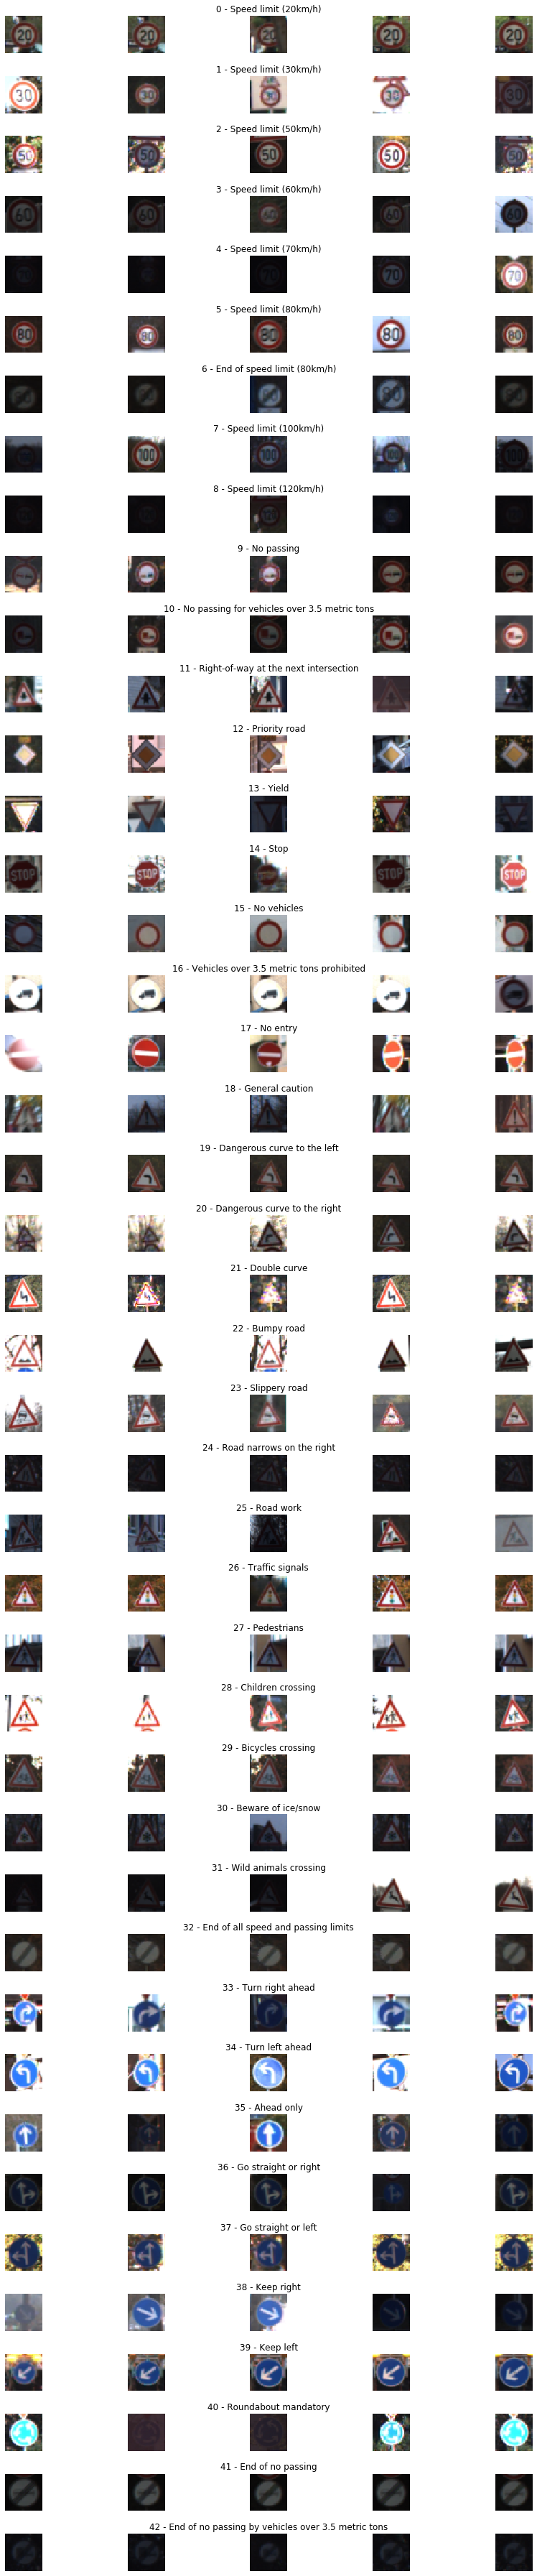

In [10]:
valid_num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(12,50))
fig.tight_layout()

for i in range(cols):
    for j, row in classes_data.iterrows():
        x_selected = X_valid[y_valid == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            valid_num_of_samples.append(len(x_selected))

### Testing Set

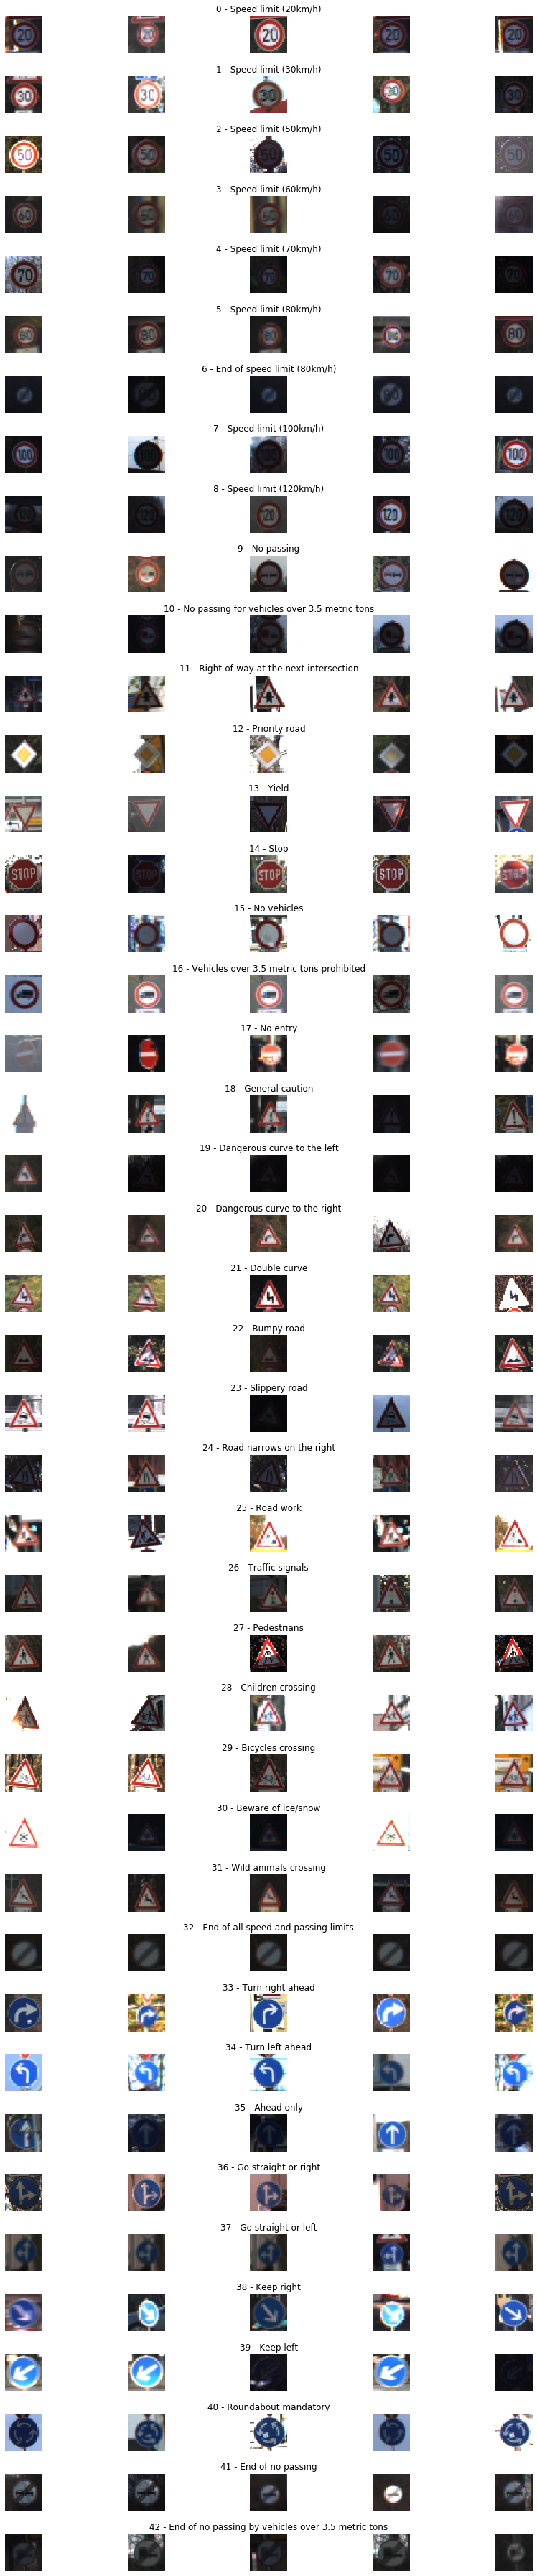

In [11]:
test_num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(12,50))
fig.tight_layout()

for i in range(cols):
    for j, row in classes_data.iterrows():
        x_selected = X_test[y_test == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            test_num_of_samples.append(len(x_selected))

#### Plotting the data

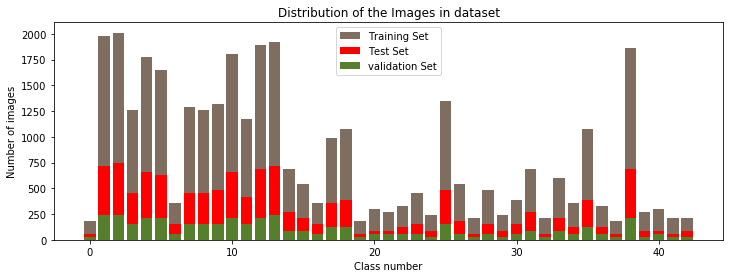

In [126]:
#print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), train_num_of_samples, color='#7f6d5f', label = 'Training Set')
plt.bar(range(0, num_classes), test_num_of_samples, color='#ff0000', label = 'Test Set')
plt.bar(range(0, num_classes), valid_num_of_samples, color='#557f2d', label = 'validation Set')

plt.title("Distribution of the Images in dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [14]:
print('Minimum Number of Samples per class :',min(train_num_of_samples))
print('Maximum Number of Samples over all classes :', max(train_num_of_samples))

Minimum Number of Samples per class : 180
Maximum Number of Samples over all classes : 2010


In [15]:
#augmentation functions

def anticlockwise_rotation(image):
    angle = random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle = random.randint(0,180)
    return rotate(image, -angle)

def horizontal_flip(image):
    return np.fliplr(image)

def vertical_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (5,5), 0)

def warp_shift(image):
    transform = AffineTransform(translation=(0,20))
    warp_image = warp(image, transform, mode = 'wrap')
    return warp_image

def brightness_change(image): 
    image = np.array(image, dtype=np.uint8) 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def rotation(image):
    angle = 25
    rot_angle = np.random.uniform(angle)-angle/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),rot_angle,1)
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    
    return image

In [16]:
transformations = { 'blur image':blur_image,
                   'brightness_change': brightness_change,
                   'rotation' : rotation
                 }

## Testing Transformations on a Test Image

In [17]:
test_image = cv2.imread('C:/Users/asaga/Documents/CVND/Self Driving car NanoDegree/Project 3/CarND-Traffic-Sign-Classifier-Project/examples/traffic_signs/3.JPG')

In [18]:
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

### Blur Image

Text(0.5, 1.0, 'Blurred Image')

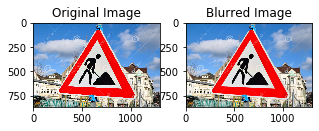

In [19]:
f,ax = plt.subplots(1,2, figsize = (5,5))
ax[0].imshow(test_image)
ax[0].set_title('Original Image')
ax[1].imshow(blur_image(test_image))
ax[1].set_title('Blurred Image')

### Alter Brigntness on the Image

Text(0.5, 1.0, 'Altered Brightness of the Image')

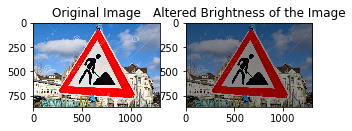

In [20]:
f,ax = plt.subplots(1,2, figsize = (5,5))
ax[0].imshow(test_image)
ax[0].set_title('Original Image')
ax[1].imshow(brightness_change(test_image))
ax[1].set_title('Altered Brightness of the Image')

### Rotation on the Image

Text(0.5, 1.0, 'Rotated Image')

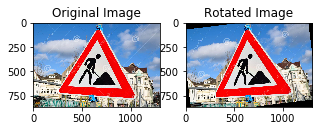

In [21]:
f,ax = plt.subplots(1,2, figsize = (5,5))
ax[0].imshow(test_image)
ax[0].set_title('Original Image')
ax[1].imshow(rotation(test_image))
ax[1].set_title('Rotated Image')

In [22]:
augmented_X = []
augmented_y = []

In [23]:
random.seed(10)

In [24]:
len(X_train[y_train == 41])

210

### Total Number of Images in each class

In [25]:
for i in range(len(classes_data)):
    print('Class {} contains {} data'.format(i, len(X_train[y_train==i])))

Class 0 contains 180 data
Class 1 contains 1980 data
Class 2 contains 2010 data
Class 3 contains 1260 data
Class 4 contains 1770 data
Class 5 contains 1650 data
Class 6 contains 360 data
Class 7 contains 1290 data
Class 8 contains 1260 data
Class 9 contains 1320 data
Class 10 contains 1800 data
Class 11 contains 1170 data
Class 12 contains 1890 data
Class 13 contains 1920 data
Class 14 contains 690 data
Class 15 contains 540 data
Class 16 contains 360 data
Class 17 contains 990 data
Class 18 contains 1080 data
Class 19 contains 180 data
Class 20 contains 300 data
Class 21 contains 270 data
Class 22 contains 330 data
Class 23 contains 450 data
Class 24 contains 240 data
Class 25 contains 1350 data
Class 26 contains 540 data
Class 27 contains 210 data
Class 28 contains 480 data
Class 29 contains 240 data
Class 30 contains 390 data
Class 31 contains 690 data
Class 32 contains 210 data
Class 33 contains 599 data
Class 34 contains 360 data
Class 35 contains 1080 data
Class 36 contains 330 d

### Image Augmentation Process 

In [26]:
for i in tqdm(range(len(classes_data))):
    x_selected = X_train[y_train == i]
    n_augment_data = int(max(train_num_of_samples) - len(x_selected))

    index_list = []
    mini_batch = min(len(x_selected), n_augment_data)
    if mini_batch <= 0:
        continue

    k = int(n_augment_data/mini_batch)
    for j in range(0,k ):
        index_list.extend(random.sample(range(len(x_selected)),mini_batch))   
    for j in index_list:
        img = x_selected[j]
        tranformation_count = random.randint(1, len(transformations))
        n = 0
        while n <= tranformation_count:
            key = random.choice(list(transformations))
            img = transformations[key](img)
            n= n+1
        augmented_X.append(img)
        augmented_y.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 11.63it/s]


In [27]:
len(augmented_X)

46888

In [28]:
len(augmented_y)

46888

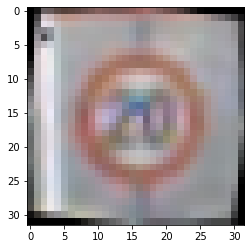

In [29]:
plt.imshow(augmented_X[1200])

In [30]:
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [31]:
print(augmented_X.shape)

(46888, 32, 32, 3)


### Saving augmented Images to the disk

In [32]:
# Create dictionary, list, etc.
augmented_data = { "features": augmented_X, "labels": augmented_y }
 
# Write to file
f_myfile = open('augmented_data_2.pickle', 'wb')
pickle.dump(augmented_data, f_myfile)
f_myfile.close()
 


### Run this cell to load the augmented data from the disk

In [ ]:
# Read from file
f_myfile = open('augmented_data_2.pickle', 'rb')
augmented_data = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

#augmented_X, augmented_y = augmented_data['features'], augmented_data['labels']

In [33]:
X_train = np.concatenate((X_train, augmented_X), axis = 0)
y_train = np.concatenate((y_train, augmented_y), axis = 0)


In [34]:
print(len(X_train))
print(len(y_train))

81687
81687


### Saving the updated Training Set to the disk

In [35]:
# Create dictionary, list, etc.
updated_data = { "features": X_train, "labels": y_train }
 
# Write to file
f_myfile = open('updated_data_2.pickle', 'wb')
pickle.dump(updated_data, f_myfile)
f_myfile.close()

In [38]:
# Helper Function to reload the updated training set from the disk

In [36]:
def reset_data():
    # Read from file
    f_myfile = open('updated_data_2.pickle', 'rb')
    updated_data = pickle.load(f_myfile)  # variables come out in the order you put them in
    f_myfile.close()

    X_t, y_t = updated_data['features'], updated_data['labels']
    
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    
    return (X_t, y_t),(X_valid, y_valid),(X_test, y_test)

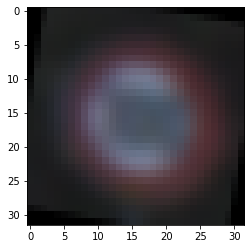

In [37]:
plt.imshow(X_train[40000]/255)

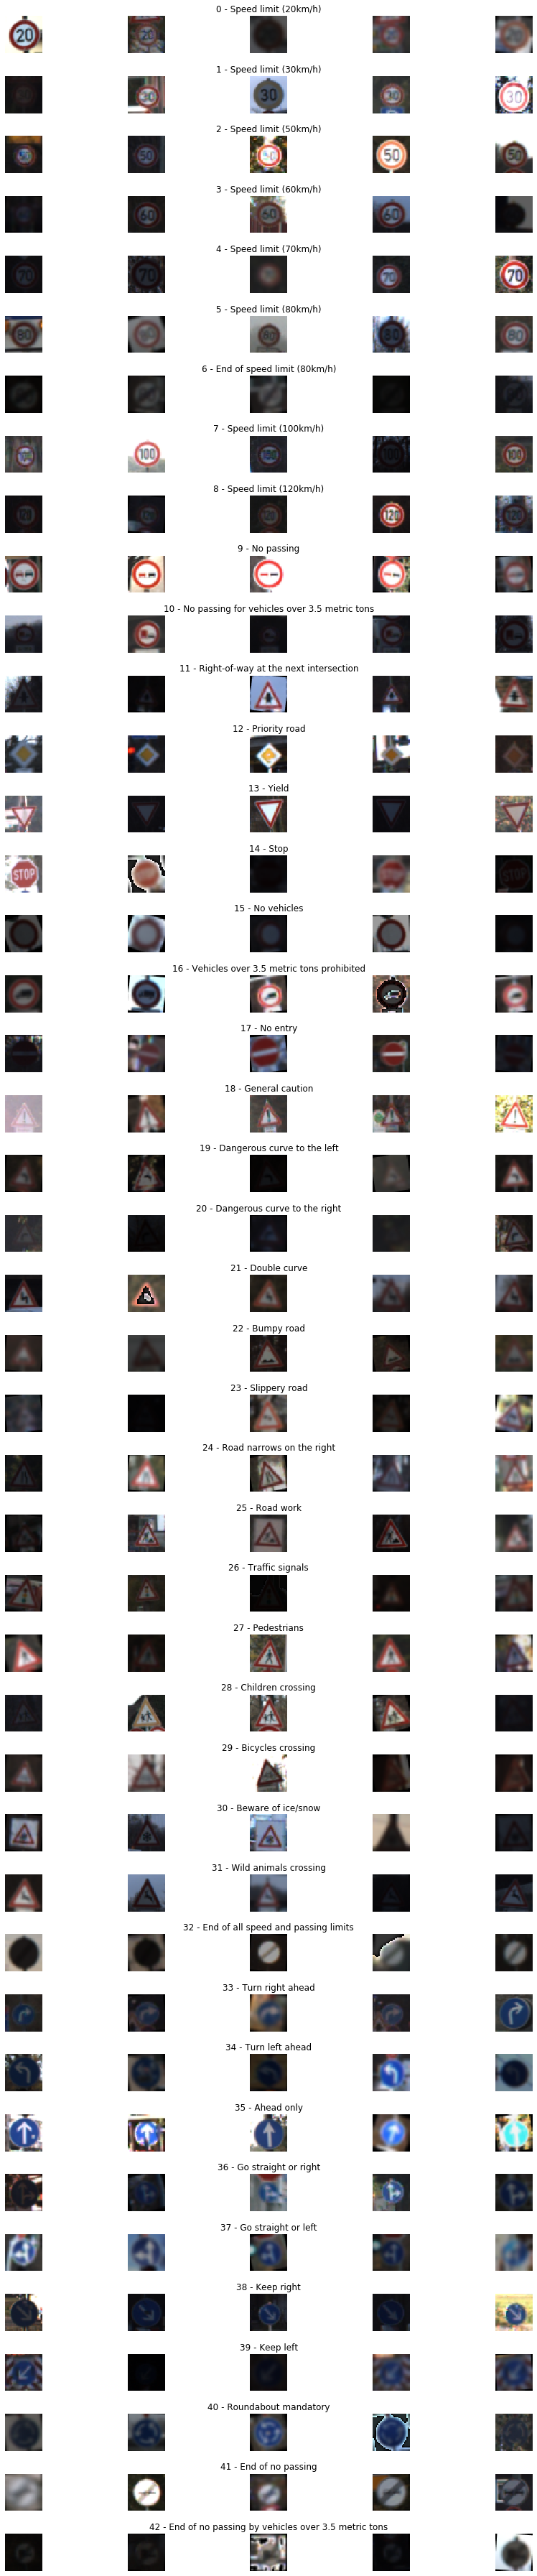

In [38]:
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(12,50))
fig.tight_layout()

for i in range(cols):
    for j, row in classes_data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow((x_selected[random.randint(0,(len(x_selected) - 1)), :, :]/255), cmap = plt.get_cmap('gray'))  
        #axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

[1980, 2010, 2010, 2010, 2010, 2010, 1800, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 1380, 1620, 1800, 1980, 2010, 1980, 1800, 1890, 1980, 1800, 1920, 2010, 1620, 1890, 1920, 1920, 1950, 1380, 1890, 1797, 1800, 2010, 1980, 1980, 2010, 1890, 1800, 1890, 1890]


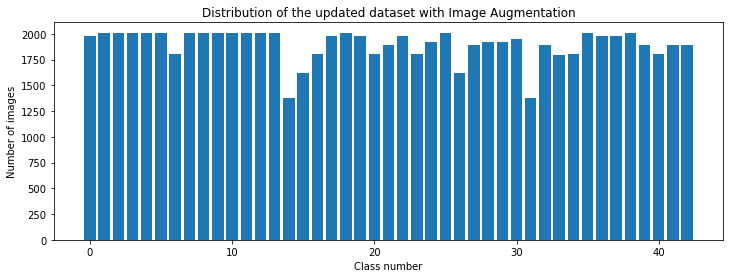

In [39]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the updated dataset with Image Augmentation")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [40]:
type(X_train)

numpy.ndarray

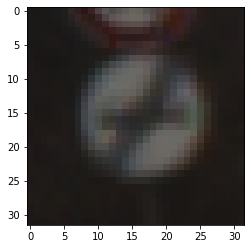

In [41]:
plt.imshow(X_train[1]/255)

### Run this cell to reload the data with augmentation

In [221]:
(X_train, y_train), (X_valid, y_valid),(X_test, y_test) = reset_data()

In [42]:
#checking integrity

print(len(X_train))
print(len(y_train))

81687
81687


In [43]:
print(X_train.shape)

(81687, 32, 32, 3)


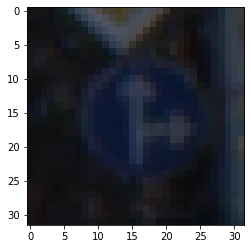

In [44]:
plt.imshow(X_train[1000]/255, cmap = plt.get_cmap('gray'))

In [45]:
print(X_test.shape)

(12630, 32, 32, 3)


In [46]:
print(X_valid.shape)

(4410, 32, 32, 3)


# Preprocessing the Image

In [47]:
test_image = X_train[1000]

In [48]:
def convert_grayscale(img):
    img = np.array(img, dtype=np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

In [49]:
def equalizeHistogram(img):
    img = cv2.equalizeHist(img)
    return img

In [50]:
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    img = clahe.apply(img)
    return img

Text(0.5, 1.0, 'CLAHE')

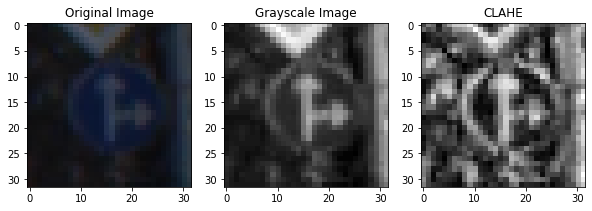

In [51]:
f, ax = plt.subplots(1,3, figsize = (10,10))

grayscale  = convert_grayscale(test_image)
#histogram_equalize = equalizeHistogram(grayscale)
clahe = CLAHE(grayscale)
ax[0].imshow(test_image, cmap = 'gray')
ax[0].set_title('Original Image')
ax[1].imshow(grayscale, cmap = 'gray')
ax[1].set_title('Grayscale Image')
ax[2].imshow(clahe, cmap = 'gray')
ax[2].set_title('CLAHE')

In [52]:
def preprocess(img):
    img = np.array(img, dtype=np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = CLAHE(img)
    img = img/255
    img = img.reshape(32,32,1)
    
    return img

In [53]:
X_train = np.array(list(map(preprocess,X_train)))

In [54]:
X_test = np.array(list(map(preprocess,X_test)))
X_valid = np.array(list(map(preprocess,X_valid)))

In [55]:
X_train.shape[1:]

(32, 32, 1)

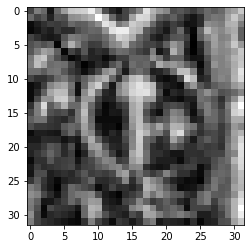

In [56]:
plt.imshow(X_train[1000].squeeze(), cmap = 'gray')

### Model Architecture

In [57]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [58]:
%load_ext tensorboard

In [59]:
import datetime

In [72]:
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 16], mean= mu, stddev= sigma)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 16, 64], mean= mu, stddev= sigma)),
    'wf1': tf.Variable(tf.truncated_normal([1600, 120], mean= mu, stddev= sigma)),
    'wf2': tf.Variable(tf.truncated_normal([120, 84], mean= mu, stddev= sigma)),
    'wf3': tf.Variable(tf.truncated_normal([84, 43], mean= mu, stddev= sigma))}

    biases = {
    'bc1': tf.Variable(tf.truncated_normal([16])),
    'bc2': tf.Variable(tf.truncated_normal([64])),
    'bf1': tf.Variable(tf.truncated_normal([120])),
    'bf2': tf.Variable(tf.truncated_normal([84])),
    'bf3': tf.Variable(tf.truncated_normal([43]))}
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    
    conv_layer_1 = tf.nn.conv2d(x, weights['wc1'], strides=[1,1,1,1],padding='VALID')
    conv_layer_1 = tf.nn.bias_add(conv_layer_1, biases['bc1'])
    
    # TODO: Activation.
    
    conv_layer_1 = tf.nn.relu(conv_layer_1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    max_pool_1 = tf.nn.max_pool(conv_layer_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #dropout_layer_1 = tf.nn.dropout(max_pool_1, rate = 0.25)
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    conv_layer_2 = tf.nn.conv2d(max_pool_1,weights['wc2'], strides=[1,1,1,1], padding= 'VALID')
    conv_layer_2 = tf.nn.bias_add(conv_layer_2, biases['bc2'])
    
    # TODO: Activation.
    
    conv_layer_2 = tf.nn.relu(conv_layer_2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.

    max_pool_2 = tf.nn.max_pool(conv_layer_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #dropout_layer_2 = tf.nn.dropout(max_pool_2, rate = 0.25)
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    flatten = tf.compat.v1.layers.Flatten()(max_pool_2)
    #tf.contrib.layers.Flatten(max_pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    
    fc1 = tf.add(tf.matmul(flatten, weights['wf1']), biases['bf1'])
    
    # TODO: Activation.
    
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
    
    # TODO: Activation.

    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    
    logits = tf.add(tf.matmul(fc2, weights['wf3']), biases['bf3'])

    
    return logits, (conv_layer_1, conv_layer_2, max_pool_1, max_pool_2)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [61]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [62]:
X_train, y_train = shuffle(X_train, y_train)

In [96]:
EPOCHS = 20
BATCH_SIZE = 128
lr = 0.0005
beta = 0.001

In [97]:
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder_with_default(1.0, shape = ())

one_hot_y  =tf.one_hot(y, 43)

In [98]:
#calculating weight decay omitting bias variables as due to small in numbers omitting them while regularizing wont affect the model 

logits, (conv_layer_1, conv_layer_2, max_pool_1, max_pool_2) = LeNet(x, keep_prob)
variables = tf.trainable_variables() 
l2_regularizer = tf.add_n([ tf.nn.l2_loss(v) for v in variables if '_b' not in v.name ])


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits= logits)
loss_operation = tf.reduce_sum(cross_entropy) + beta * l2_regularizer
optimizer = tf.train.AdamOptimizer(learning_rate= lr)
training_operation = optimizer.minimize(loss_operation)

In [99]:
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y, 1))
accuracy_prediction = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_prediction, feed_dict = {x: batch_x, y: batch_y})
        total_accuracy += (accuracy *len(batch_x))
    return total_accuracy/num_examples

In [100]:
val_acc, train_acc, loss = [],[],[]
train_mean = []

In [101]:
with tf.Session() as sess:
    #writer = tf.summary.FileWriter("/logs/v1.1", sess.graph)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        train_mean = []
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, cost = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_mean.append(evaluate(batch_x, batch_y))
        
        #Checking Validation Accuracy after every epoch
        valid_accuracy = evaluate(X_valid, y_valid)
        #train_accuracy = evaluate(X_train, y_train)
        val_acc.append(valid_accuracy)
        train_acc.append(np.mean(train_mean))
        print('Epoch: {:>2d}/{:>2d} Train Accuracy: {:.3f} Validation Accuracy: {:.3f}'.format(i+1, EPOCHS, np.mean(train_mean), valid_accuracy))
        
        loss.append(cost)
        #tf.summary.scalar('Validation_Accuracy', valid_accuracy)
        #tf.summary.scalar('Training_Accuracy', train_accuracy)
    saver.save(sess, './lenet')
    print("Model saved")

Training...

Epoch:  1/20 Train Accuracy: 0.259 Validation Accuracy: 0.597
Epoch:  2/20 Train Accuracy: 0.693 Validation Accuracy: 0.812
Epoch:  3/20 Train Accuracy: 0.809 Validation Accuracy: 0.853
Epoch:  4/20 Train Accuracy: 0.862 Validation Accuracy: 0.897
Epoch:  5/20 Train Accuracy: 0.894 Validation Accuracy: 0.919
Epoch:  6/20 Train Accuracy: 0.911 Validation Accuracy: 0.925
Epoch:  7/20 Train Accuracy: 0.924 Validation Accuracy: 0.939
Epoch:  8/20 Train Accuracy: 0.933 Validation Accuracy: 0.939
Epoch:  9/20 Train Accuracy: 0.941 Validation Accuracy: 0.949
Epoch: 10/20 Train Accuracy: 0.949 Validation Accuracy: 0.958
Epoch: 11/20 Train Accuracy: 0.954 Validation Accuracy: 0.957
Epoch: 12/20 Train Accuracy: 0.958 Validation Accuracy: 0.958
Epoch: 13/20 Train Accuracy: 0.963 Validation Accuracy: 0.963
Epoch: 14/20 Train Accuracy: 0.966 Validation Accuracy: 0.969
Epoch: 15/20 Train Accuracy: 0.968 Validation Accuracy: 0.969
Epoch: 16/20 Train Accuracy: 0.970 Validation Accuracy: 0

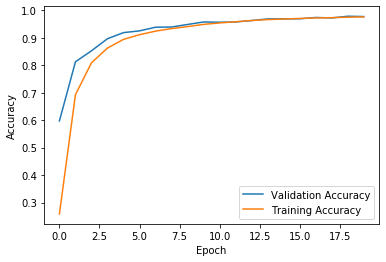

In [102]:
plt.plot(val_acc ,label = 'Validation Accuracy')
plt.plot(train_acc, label = 'Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

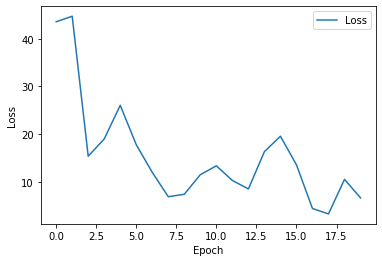

In [103]:
plt.plot(loss ,label = 'Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [104]:

with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Train Accuracy = 0.977
Test Accuracy = 0.948


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [81]:
test_image_paths = glob.glob('C:/Users/asaga/Documents/CVND/Self Driving car NanoDegree/Project 3/CarND-Traffic-Sign-Classifier-Project/examples/traffic_signs/*.jpg')

In [82]:
example_images = []

for idx , fname in enumerate(test_image_paths):
    image = cv2.imread(fname)
    image = cv2.resize(image, (32,32))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = CLAHE(image)
    image = image/255
    image = image.reshape(32,32,1)
    example_images.append(image)

In [83]:
example_output_labels = [23, 40, 22, 25, 28, 2, 1, 13, 36, 33]

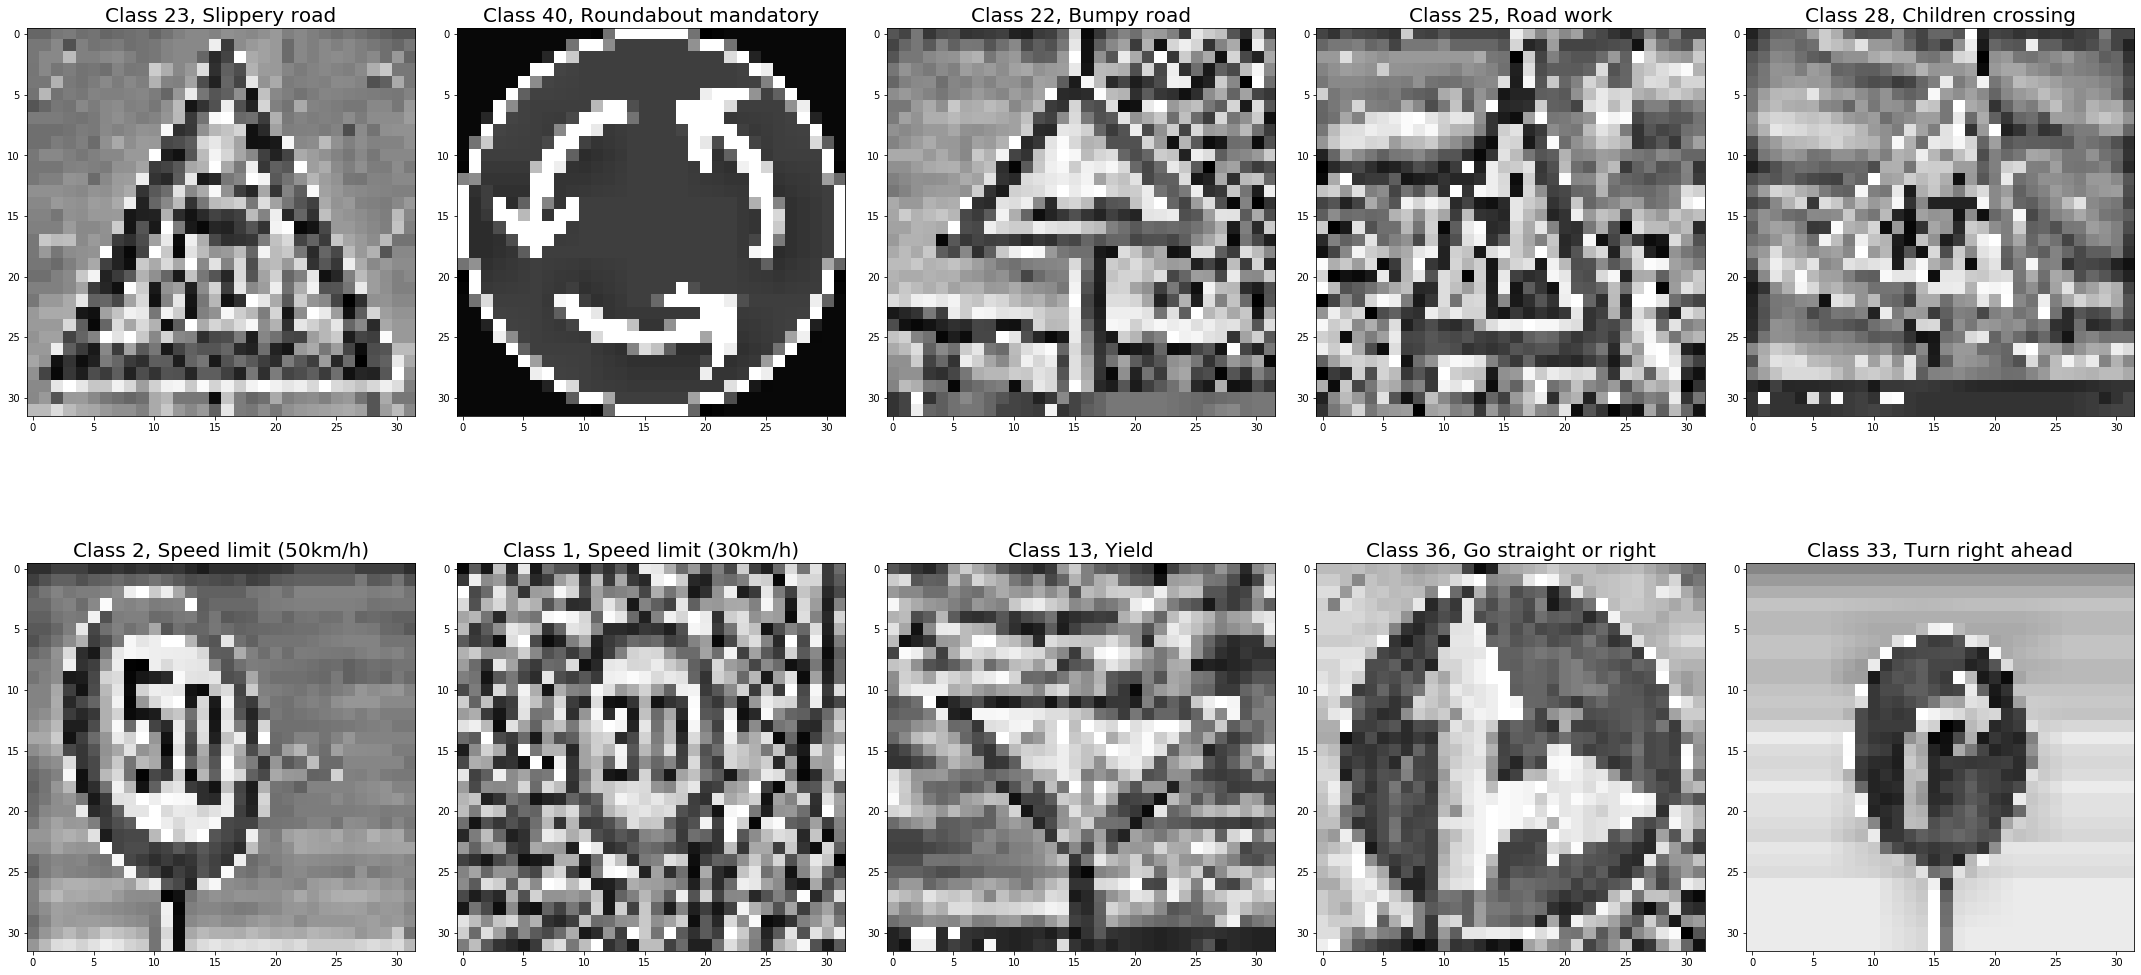

In [84]:
f, ax = plt.subplots(2,5, figsize = (30,15))
f.tight_layout()
j = 0
for i in range(len(example_images)):
    
    if i>4:
        ax[1][abs(5-i)].imshow(example_images[i].squeeze(), cmap = 'gray')
        ax[1][abs(5-i)].set_title('Class {}, {}'.format(example_output_labels[i], classes_data['SignName'][example_output_labels[i]]), fontsize = 20)
    else:
        ax[0][i].imshow(example_images[i].squeeze(), cmap = 'gray')
        ax[0][i].set_title('Class {}, {}'.format(example_output_labels[i], classes_data['SignName'][example_output_labels[i]]), fontsize = 20)
    #ax[i].set_title('Class {}, {}'.format(example_output_labels[i], classes_data['SignName'][example_output_labels[i]]), fontsize = 20)

### Predict the Sign Type for Each Image

In [196]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [105]:
pred_val = tf.argmax(logits,1)
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_val_out = sess.run( pred_val, feed_dict={x:  example_images, y: example_output_labels})
    
print("Predicted Labels  :", pred_val_out)
    
cnt = 0
correct_cnt = 0
for i in range(len(pred_val_out)):
    correctness = "Correct"
    j = pred_val_out[i]
    if example_output_labels[cnt] == j:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
    
    print("Image {} Predicted Class {}  Actual Class {}  ({})".format(i,j, classes_data['ClassId'][example_output_labels[i]], classes_data['SignName'][example_output_labels[i]] ))
    cnt = cnt + 1
    
print("Prediction Rate {}%".format(correct_cnt * 100/cnt))

INFO:tensorflow:Restoring parameters from .\lenet
Predicted Labels  : [23 40  9 25 28 40 13 13 36 33]
Image 0 Predicted Class 23  Actual Class 23  (Slippery road)
Image 1 Predicted Class 40  Actual Class 40  (Roundabout mandatory)
Image 2 Predicted Class 9  Actual Class 22  (Bumpy road)
Image 3 Predicted Class 25  Actual Class 25  (Road work)
Image 4 Predicted Class 28  Actual Class 28  (Children crossing)
Image 5 Predicted Class 40  Actual Class 2  (Speed limit (50km/h))
Image 6 Predicted Class 13  Actual Class 1  (Speed limit (30km/h))
Image 7 Predicted Class 13  Actual Class 13  (Yield)
Image 8 Predicted Class 36  Actual Class 36  (Go straight or right)
Image 9 Predicted Class 33  Actual Class 33  (Turn right ahead)
Prediction Rate 70.0%


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [106]:
pred_top5 = tf.nn.top_k(tf.nn.softmax(logits), k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_top5_out = sess.run( pred_top5, feed_dict={x:  example_images, y: example_output_labels})

INFO:tensorflow:Restoring parameters from .\lenet


In [107]:
type(pred_top5_out)

tensorflow.python.ops.gen_nn_ops.TopKV2

In [108]:
pred_top5_out.values

array([[8.4390420e-01, 9.3231946e-02, 1.9520899e-02, 1.2508353e-02,
        1.1197819e-02],
       [9.2905629e-01, 3.6939975e-02, 1.0343753e-02, 3.6709351e-03,
        2.6978762e-03],
       [7.5836265e-01, 7.9222962e-02, 7.1921222e-02, 2.9536923e-02,
        2.2716152e-02],
       [9.4097239e-01, 3.8091015e-02, 1.6535895e-02, 3.9093755e-03,
        1.7719937e-04],
       [9.6242242e-02, 8.6345240e-02, 6.5787457e-02, 6.5349855e-02,
        4.9788002e-02],
       [2.0374174e-01, 9.3606256e-02, 7.8397386e-02, 6.7354009e-02,
        5.3060494e-02],
       [1.9586994e-01, 1.4197144e-01, 1.4132738e-01, 1.0176376e-01,
        6.0393285e-02],
       [7.1948600e-01, 9.2693709e-02, 6.9127031e-02, 3.2835584e-02,
        2.6571220e-02],
       [9.2991829e-01, 2.6719136e-02, 1.8606383e-02, 1.5688667e-02,
        4.3040584e-03],
       [4.3879664e-01, 2.7561644e-01, 1.8414117e-01, 7.3194019e-02,
        1.2488225e-02]], dtype=float32)

In [109]:
pred_top5_out.indices

array([[23, 30, 20, 19, 11],
       [40, 12, 17, 30, 16],
       [ 9, 16, 35,  3, 15],
       [25, 26, 22, 31, 18],
       [28,  6,  5,  0, 34],
       [40, 30, 37, 21, 26],
       [13,  4,  0,  8, 39],
       [13, 34, 35, 15, 36],
       [36, 18, 27, 32, 26],
       [33, 15, 35, 13,  3]])

In [110]:
print(len(pred_top5_out.indices))
print(len(pred_top5_out.indices[0]))

10
5


### Displaying the Top 5 class predictions of each Image

In [111]:

for i in range(len(pred_top5_out.indices)):
    print('For Image {}'.format(i+1))
    print('Correct Label      :{}'.format(classes_data['SignName'][example_output_labels[i]]))
    print('1st Detected Label :{}'.format(classes_data['SignName'][pred_top5_out.indices[i][0]]))
    print('2nd Detected Label :{}'.format(classes_data['SignName'][pred_top5_out.indices[i][1]]))
    print('3rd Detected Label :{}'.format(classes_data['SignName'][pred_top5_out.indices[i][2]]))
    print('4th Detected Label :{}'.format(classes_data['SignName'][pred_top5_out.indices[i][3]]))
    print('5th Detected Label :{}'.format(classes_data['SignName'][pred_top5_out.indices[i][4]]))
    print()

For Image 1
Correct Label      :Slippery road
1st Detected Label :Slippery road
2nd Detected Label :Beware of ice/snow
3rd Detected Label :Dangerous curve to the right
4th Detected Label :Dangerous curve to the left
5th Detected Label :Right-of-way at the next intersection

For Image 2
Correct Label      :Roundabout mandatory
1st Detected Label :Roundabout mandatory
2nd Detected Label :Priority road
3rd Detected Label :No entry
4th Detected Label :Beware of ice/snow
5th Detected Label :Vehicles over 3.5 metric tons prohibited

For Image 3
Correct Label      :Bumpy road
1st Detected Label :No passing
2nd Detected Label :Vehicles over 3.5 metric tons prohibited
3rd Detected Label :Ahead only
4th Detected Label :Speed limit (60km/h)
5th Detected Label :No vehicles

For Image 4
Correct Label      :Road work
1st Detected Label :Road work
2nd Detected Label :Traffic signals
3rd Detected Label :Bumpy road
4th Detected Label :Wild animals crossing
5th Detected Label :General caution

For Image

### Displaying Softmax Probability

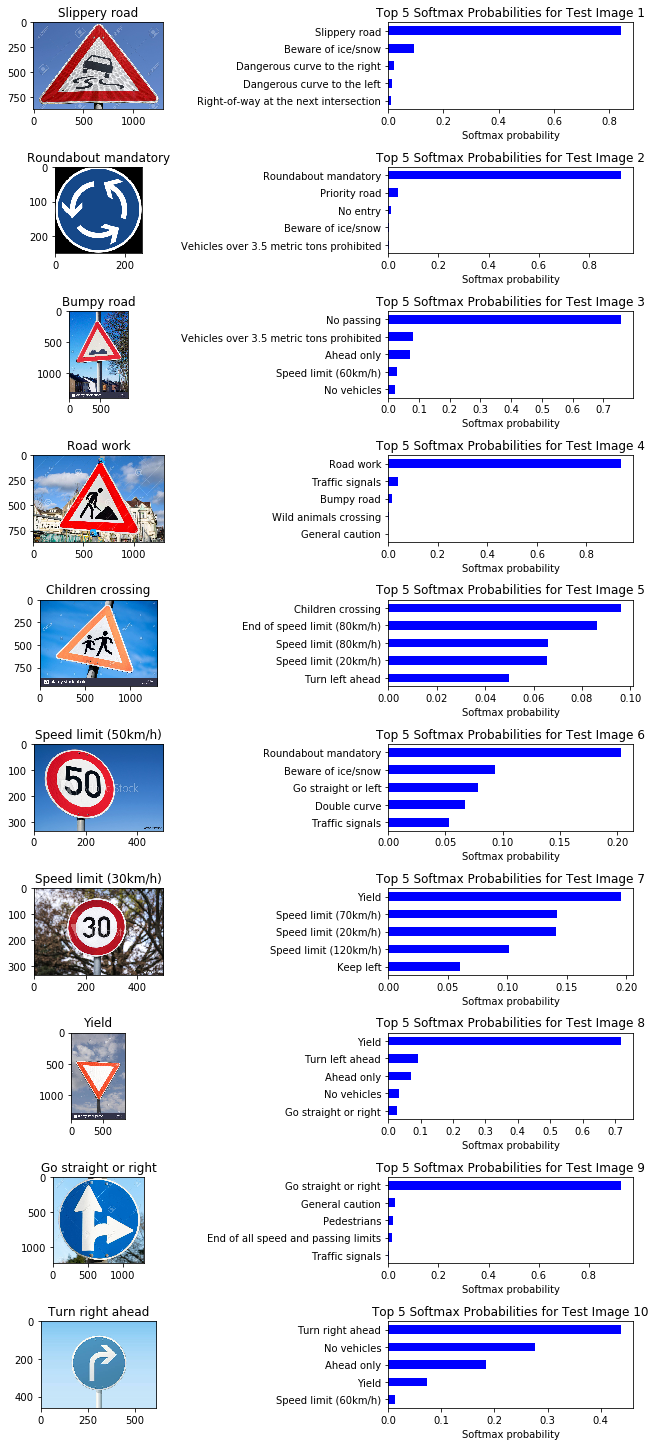

In [113]:
top_k_values = pred_top5_out.values
top_k_indices = pred_top5_out.indices

ind = np.arange(5) 

f, ax = plt.subplots(10,2, figsize = (10,20))

for i in range(10):
    f.tight_layout()
    values = top_k_values[i]
    labels = [classes_data['SignName'][v] for v in top_k_indices[i]]
    ax[i][0].imshow(cv2.cvtColor(cv2.imread(test_image_paths[i]), cv2.COLOR_BGR2RGB))
    ax[i][0].set_title(classes_data['SignName'][example_output_labels[i]])
    ax[i][1].barh(ind, values, 0.5, color='b')
    ax[i][1].set_xlabel('Softmax probability')
    ax[i][1].set_title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    ax[i][1].set_yticks(ind)
    ax[i][1].set_yticklabels(labels)
    ax[i][1].invert_yaxis()

plt.show()

### Test data set Details

In [114]:
print(X_test.shape)

(12630, 32, 32, 1)


In [115]:
pred_val = tf.argmax(logits,1)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy, test_pred = sess.run([accuracy_prediction, pred_val], feed_dict={x:X_test, y:y_test})

INFO:tensorflow:Restoring parameters from .\lenet


In [116]:
for i in range(len(classes_data)):
    print('Class {} contains {} data'.format(i, len(X_test[y_test==i])))

Class 0 contains 60 data
Class 1 contains 720 data
Class 2 contains 750 data
Class 3 contains 450 data
Class 4 contains 660 data
Class 5 contains 630 data
Class 6 contains 150 data
Class 7 contains 450 data
Class 8 contains 450 data
Class 9 contains 480 data
Class 10 contains 660 data
Class 11 contains 420 data
Class 12 contains 690 data
Class 13 contains 720 data
Class 14 contains 270 data
Class 15 contains 210 data
Class 16 contains 150 data
Class 17 contains 360 data
Class 18 contains 390 data
Class 19 contains 60 data
Class 20 contains 90 data
Class 21 contains 90 data
Class 22 contains 120 data
Class 23 contains 150 data
Class 24 contains 90 data
Class 25 contains 480 data
Class 26 contains 180 data
Class 27 contains 60 data
Class 28 contains 150 data
Class 29 contains 90 data
Class 30 contains 150 data
Class 31 contains 270 data
Class 32 contains 60 data
Class 33 contains 210 data
Class 34 contains 120 data
Class 35 contains 390 data
Class 36 contains 120 data
Class 37 contains 6

# Analysing the Result on Test Images

### Precision and Recall Score for all classes of Test Data

In [117]:
precision = []
recall = []

for i in range(43):
    p_score = np.count_nonzero(test_pred[y_test==i] ==i) / np.count_nonzero(test_pred == i)
    r_score = np.count_nonzero(test_pred[y_test == i]==i) / np.count_nonzero(y_test == i)
    precision.append(p_score)
    recall.append(r_score)

In [118]:
print('Precision and Recall scores of the classes')
for i in range(43):
    print('Class {} Precision Score :{:.2f}% Recall Score :{:.2f}%'
          .format(i, precision[i]*100, recall[i]*100))

Precision and Recall scores of the classes
Class 0 Precision Score :82.86% Recall Score :96.67%
Class 1 Precision Score :96.19% Recall Score :94.72%
Class 2 Precision Score :94.16% Recall Score :98.93%
Class 3 Precision Score :95.73% Recall Score :84.67%
Class 4 Precision Score :97.41% Recall Score :96.97%
Class 5 Precision Score :86.71% Recall Score :93.17%
Class 6 Precision Score :98.43% Recall Score :83.33%
Class 7 Precision Score :94.73% Recall Score :95.78%
Class 8 Precision Score :97.25% Recall Score :94.22%
Class 9 Precision Score :99.17% Recall Score :99.38%
Class 10 Precision Score :97.60% Recall Score :98.64%
Class 11 Precision Score :93.46% Recall Score :91.90%
Class 12 Precision Score :99.56% Recall Score :97.68%
Class 13 Precision Score :98.76% Recall Score :99.58%
Class 14 Precision Score :99.26% Recall Score :99.63%
Class 15 Precision Score :95.85% Recall Score :99.05%
Class 16 Precision Score :98.68% Recall Score :99.33%
Class 17 Precision Score :99.15% Recall Score :96

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [119]:
def FeatureMap(image_input, output, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input, y: output})
    with tf.Session() as sess:
    
        saver.restore(sess, '.\lenet')
        activation = sess.run(tf_activation, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for i,featuremap in enumerate(range(featuremaps)):
        if i==48:
            break
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [120]:
example_image = example_images[0].reshape(1,32,32,1)

In [121]:
example_image = np.array(example_image)

In [122]:
example_output_labels = np.array(example_output_labels)

INFO:tensorflow:Restoring parameters from .\lenet


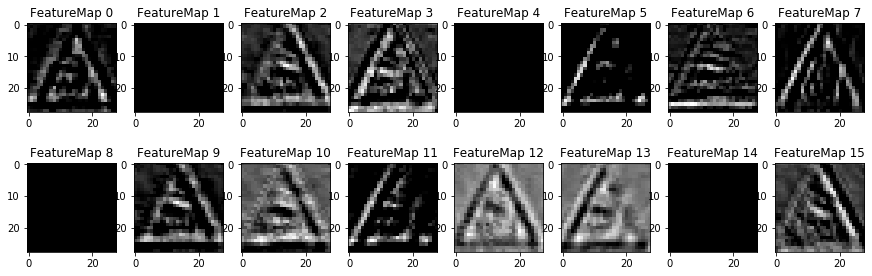

In [123]:
FeatureMap(example_image,4,conv_layer_1)

INFO:tensorflow:Restoring parameters from .\lenet


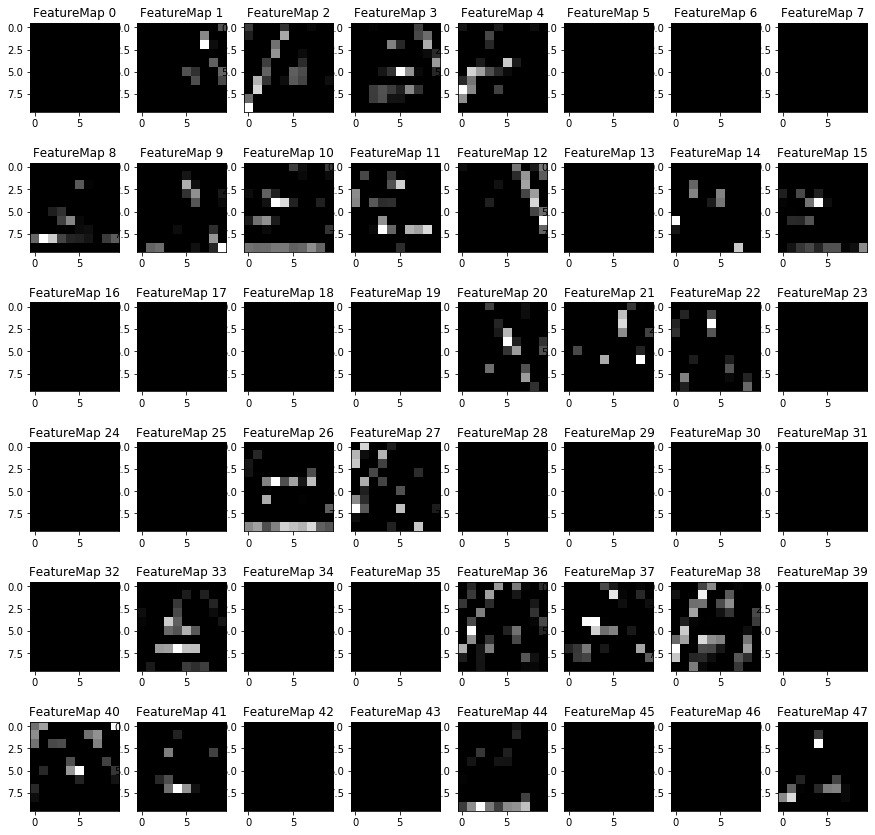

In [124]:
FeatureMap(example_image,4,conv_layer_2)

INFO:tensorflow:Restoring parameters from .\lenet


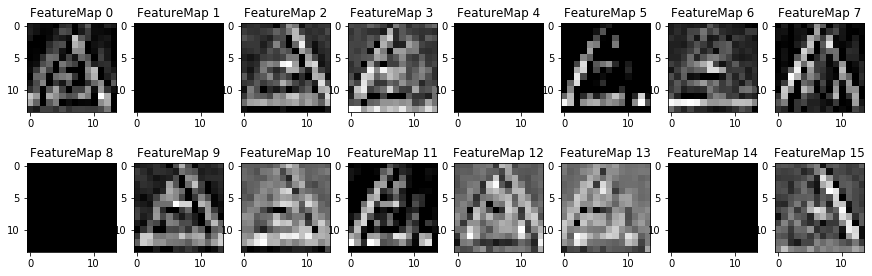

In [125]:
FeatureMap(example_image,4,max_pool_1)